## Implementation of Easy21
You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s
0
(which may be terminal if the game is finished)
and reward r. We will be using this environment for model-free reinforcement
learning, and you should not explicitly represent the transition matrix for the
MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as
part of the environment, i.e. calling step with a stick action will play out the
dealer’s cards and return the final reward and terminal state.

See if you can take the assignment beyond the minimal requirements before the application date 01/12/2020.

## Much more OOP design

* Should start with Dealer and Player and then design the required interactions.
* Not meant to track the states within the environment.

Instead of trying to improve the Monte-Carlo solution work on Understanding TD(0) and TD(lambda)

https://www.reddit.com/r/reinforcementlearning/comments/9sh77q/what_are_your_best_tips_for_debugging_rl_problems/
-> Excellent discussion of approaches to practical Reinforcement Learning.

* https://pierrealexsw.github.io/2018/09/21/Easy21/
* https://github.com/aiot-tech/reinforcement-learning-David-Silver
* http://www.wildml.com/2016/10/learning-reinforcement-learning/

In [1]:
import logging
import pandas as pd
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

In [2]:
import random
import pickle

# due to replacement, state is fully represented by previous sum and dealer's initial card
# abstract away colours and actions
class Easy21:
    """
    Be really strict with your implementation relative to the problem criteria
    Where did your player_threshold come from / is it used??
    Score is completely separate to reward
    If the player’s sum exceeds 21, or becomes less than 1, then she “goes
    bust” and loses the game (reward -1) -> instant loss, irrespective of dealer.
    """
    def __init__(self, player_threshold=16):
        self.dealer_score, self.player_score = random.choice(list(range(1,11))), random.choice(list(range(1,11)))
        self.terminated = False
        self.reward = 0 

    def evaluate_winner(self):
        "Determine returns -> if player goes bust at all they lose irrespective of dealer cards."
        if self.player_score < 1 or self.player_score > 21:
            self.reward = -1
        elif self.dealer_score == self.player_score:
            self.reward = 0 # is there a default winner? e.g. dealer?
        else:
            self.reward = 1 if self.player_score > self.dealer_score else -1

    def update(self, score):
        "Update the state wrt one character or the other."
        #print(self.player_score, self.dealer_score, self.reward)
        colour = random.choice([-1,1,1])
        card = random.choice(list(range(1,11)))
        new_score = score + (colour*card)
        if (new_score > 21 or new_score < 1):
            self.terminated = True
            return new_score
        else:
            return new_score 
    
    
    def play_out_dealer(self):
        "Terminate the game and retrieve the dealer's score"
        if self.reward != -1 and self.terminated == False:
            while self.dealer_score <= 16 and self.dealer_score >= 1: # should be greater than or equal to 1
                self.dealer_score = self.update(self.dealer_score)
        self.terminated = True
        self.evaluate_winner()
        return self.reward, self.dealer_score, self.player_score
    
    def step(self, player_score, dealer_score, action):
        """
        If action == 1 carry out players move, else terminate game and retrieve dealer's score. Need to be able to play
        complete game by repeatedly calling this method.
        """
        if action == 1:
            self.player_score = self.update(self.player_score)
        else:
            self.play_out_dealer()
        return self.player_score, self.dealer_score, self.reward, self.terminated #action taken and both scores that result
            
        
    def play(self):
        "Carry out complete game and return the reward and terminal state."
        self.init()
        while self.terminal == False:
            self.step()
        return self.reward, self.dealer_score, self.player_score # reward and terminal state.
     

## Monte-Carlo Control in Easy21
Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use
a time-varying scalar step-size of αt = 1/N(st, at) and an -greedy exploration
strategy with t = N0/(N0 + N(st)), 
where:

* N0 = 100 is a constant, 
* N(s) is the number of times that state s has been visited, and 
* N(s, a) is the number of times that action a has been selected from state s. 

Feel free to choose an alternative value for N0, if it helps producing better results. Plot the optimal value function V.

(s) = maxa Q∗
(s, a) using similar axes to the following figure
taken from Sutton and Barto’s Blackjack example.

To begin, let us consider a Monte Carlo version of classical policy iteration. In this method, we
perform alternating complete steps of policy evaluation and policy improvement

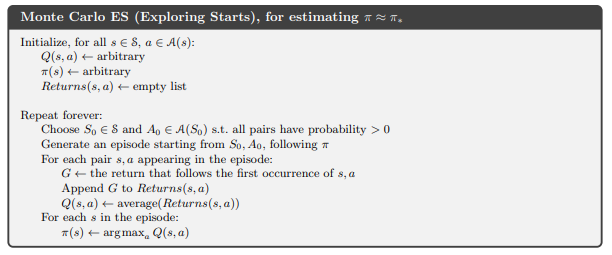

Use dealer behaviour as initialisation. The only parameter available is when you stick. Given there is no time / replacement component to the problem a given sum is a fully unique state. 

<b> State </b> = dealer's first card and sum of players cards thus far. At least get this part done today (17/11/2020)

Vπ(s) is the state-value function of MDP (Markov Decision Process). It's the expected return starting from state s following policy π.
 
tibMG's implementation is much much cleaner. https://github.com/timbmg/easy21-rl/blob/master/environment.py

## Epsilon Greedy

https://medium.com/analytics-vidhya/the-epsilon-greedy-algorithm-for-reinforcement-learning-5fe6f96dc870
The Epsilon-Greedy Algorithm makes use of the exploration-exploitation tradeoff by
instructing the computer to explore (i.e. choose a random option with probability epsilon)
and exploit (i.e. choose the option which so far seems to be the best) the remainder of the time.

Epsilon is the parameter that controls the probability of exploration. Larger epsilon = more exploration. In this instance it's set to be inversely proportional to the number of times that state has been visited. The less well understood a state is, the more valuable exploring is.
    -> Surely it could also be valuable to add a relationship to rewards from the state? 
    
Epsilon Greedy with a set value of epsilon is the policy. Every change to epsilon is the update of the policy.


In [3]:
import numpy as np

printEvery = 100
actions = [0, 1]
N0 = 100

# state, action function
Q = np.zeros((22, 11, len(actions)))

# number of times action a has been choosen in state s
NSA = np.zeros((22, 11, len(actions)))

# number of times state s has been visited
def NS(p, d):
    return np.sum(NSA[p, d])

# step size
def alpha(p, d, a):
    return 1 / NSA[p, d, a]

# exploration probability
# it is a function of the number of times a given state has been explored. 
# e.g. explicitly encodes the need to explore areas that are less well explored.
def epsilon(p, d):
    return N0 / (N0 + NS(p, d))

# experiment with decaying epsilon?
def epsilonGreedy(p, d):
    if np.random.random() < epsilon(p, d):
        # explore (pick randomly)
        action = np.random.choice(actions) # only hit or stick

    else:
        # exploit (do the best so far available)
        action = np.argmax( [Q[p, d, a] for a in actions] )

    return action

episodes = int(5e5)
meanReturn = 0
wins = 0


for episode in range(episodes):
    terminated = False
    SAR = list() # state, action, reward
    env = Easy21()
    while env.terminated == False: # play a single full game
        #print(env.player_score, env.dealer_score)
        a = epsilonGreedy(env.player_score, env.dealer_score)
        p, d = env.player_score, env.dealer_score

        NSA[env.player_score, env.dealer_score, a] += 1

        pPrime, dPrime, r, terminated = env.step(env.player_score, env.dealer_score, a)

        SAR.append([p, d, a, r]) # (p, d) = state, a = action, r = reward

        env.player_score, env.dealer_score = pPrime, dPrime
    
    #print('Game finally terminated')
    # Update Q
    G = sum([sar[-1] for sar in SAR]) # sum all rewards
    for (p, d, a, _) in SAR: # should work
        # alpha = steep size, 
        #this is updating the value function in the direction of the error signal (David Silver's words)
        #this is what you understand least well so far. How the value function is actually built.
        Q[p, d, a] += alpha(p, d, a) * (G - Q[p, d, a])

    # bookkeeping
    meanReturn = meanReturn + 1/(episode+1) * (G - meanReturn)
    if r == 1:
        wins += 1

    episode_list, mean_returns, win_list = [], [], []
    if episode % 100000 == 0:
        # why is the numebr of wins going down over time?
        print("Episode %i, Mean-Return %.3f, Wins %.2f"%(episode, meanReturn, wins/(episode+1)))
        episode_list.append(episode)
        mean_returns.append(meanReturn)
        win_list.append(wins/(episode+1))
        

Episode 0, Mean-Return -1.000, Wins 0.00
Episode 10000, Mean-Return -0.144, Wins 0.32
Episode 20000, Mean-Return -0.112, Wins 0.31
Episode 30000, Mean-Return -0.085, Wins 0.31
Episode 40000, Mean-Return -0.060, Wins 0.30
Episode 50000, Mean-Return -0.039, Wins 0.29
Episode 60000, Mean-Return -0.022, Wins 0.29
Episode 70000, Mean-Return -0.009, Wins 0.29
Episode 80000, Mean-Return 0.002, Wins 0.29
Episode 90000, Mean-Return 0.011, Wins 0.29
Episode 100000, Mean-Return 0.020, Wins 0.28
Episode 110000, Mean-Return 0.027, Wins 0.28
Episode 120000, Mean-Return 0.033, Wins 0.28
Episode 130000, Mean-Return 0.039, Wins 0.28
Episode 140000, Mean-Return 0.045, Wins 0.28
Episode 150000, Mean-Return 0.050, Wins 0.28
Episode 160000, Mean-Return 0.055, Wins 0.28
Episode 170000, Mean-Return 0.059, Wins 0.28
Episode 180000, Mean-Return 0.063, Wins 0.28
Episode 190000, Mean-Return 0.066, Wins 0.27
Episode 200000, Mean-Return 0.069, Wins 0.27
Episode 210000, Mean-Return 0.071, Wins 0.27
Episode 220000, 

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set()

def plot(Q, actions):

    from mpl_toolkits.mplot3d import Axes3D

    pRange = list(range(1,22))
    dRange = list(range(1,11))
    vStar = list()
    for p in pRange:
        for d in dRange:
            vStar.append( [p, d, np.max([Q[p, d, a] for a in actions])] )

    df = pd.DataFrame(vStar, columns=['player', 'dealer', 'value'])

    # And transform the old column name in something numeric
    # df['player']=pd.Categorical(df['player'])
    # df['player']=df['player'].cat.codes

    # Make the plot
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
    ax.set_xlabel("Dealer's Hand", fontsize=20)
    ax.set_ylabel("Player's Hand", fontsize=20)
    ax.set_zlabel("P( stick )", fontsize=20)
    plt.show()

    # to Add a color bar which maps values to colors.
    surf=ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
    fig.colorbar( surf, shrink=0.5, aspect=5)
    plt.show()

    # Rotate it
    ax.view_init(30, 45)
    plt.show()

    # Other palette
    ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap='magma', linewidth=0.01)
    plt.show()

#plot(Q, [0,1])


Value function can be very complicated even if a reasonable policy is very simple.

## What is TD (Temporal-Difference) Learning?

Value function is updated more regularly. e.g. don't have to wait until the game is complete to update.

TD(0)
https://towardsdatascience.com/temporal-difference-learning-47b4a7205ca8
TD(0) is the simplest form of TD learning. In this form of TD learning, after every step value function is updated with the value of the next state and along the way reward obtained. This observed reward is the key factor that keeps the learning grounded and algorithm converges after a sufficient number of sampling (in the limit of infinity). Below is the backup diagram of TD(0) and an example of TD(0) for our gem collection and examination example.

<b> TD(0) and monte-carlo are opposite ends of a spectrum. </b>

Q) TD(0) would presumably perform pooly in a scenario where its often beneficial to undergo short-term loss for long term gain.

Monte-carlo sees each episode through to the end so its using 'real' values as opposed to the estimates used in TD learning.

ONLINE = immediate update
OFFLINE = defer the updates to the end of the episode

## TD Lambda

Uses the lambda return. Geometrically weighted average of all n.
The geometric weightings are memoryless and therefore efficient to compute. Can do TD Lambda for the same cost as TD(0)

## Sarsa

Sarsa is an example of a TD algorithm.


### Credit Assignment Problem 
* Frequency heuristic - assign credit for the results to the most frequent states.
* Recency heuristic - assign credit to most recent states.

* Eligibility traces combine both heuristics

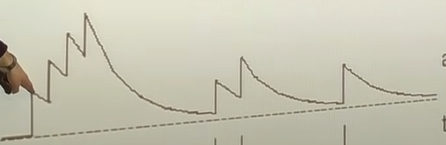 
Every spike is a visit to a state and the significance of that visit tails off as an exponential. You therefore get build-up (frequency) but also recency (exponential fall-of)

Storing the values in an array is just a specific case of the more general approach of function approximation.

## Eligibility Traces


When a TD error occurs, only the eligible states
or actions are assigned credit or blame for the error. <b> Thus, eligibility traces
help bridge the gap between events and training information</b>. They allow you to propagate information backwards (/ away from the target / burst of reward).

### Monte-Carlo well-defined (at opposite end of the spectrum to TD(0))
*  Monte Carlo
methods perform a backup for each state based on the entire sequence of
observed rewards from that state until the end of the episode. 

### Temporal Difference
* Use the approximated value of the next state as a proxy for the remaining rewards. 
https://meatba11.medium.com/reinforcement-learning-td-%CE%BB-introduction-2-f0ea427cd395
"The methods that use n-step backups are still TD methods because they
still change an earlier estimate based on how it differs from a later estimate."

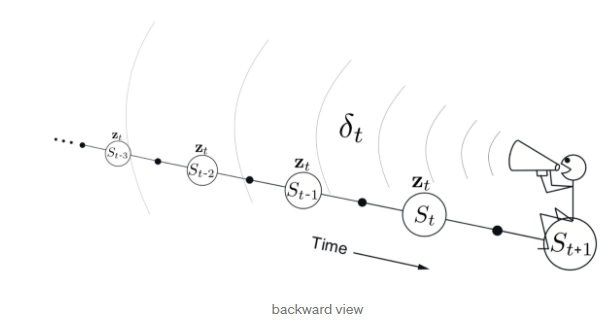

## Policy based Reinforcement Learning

* Value based RL learns a near-deterministic policy. Performs poorly in environments that require stochasticisty (e.g. rock paper scissors)
* Some cases where the optimum policy is simple but the value function would still be extremely complex.

"TD learning methods update targets with regard to existing estimates rather than exclusively relying on actual rewards and complete returns as in MC methods" https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#temporal-difference-learning

SARSA = on-policy TD control 

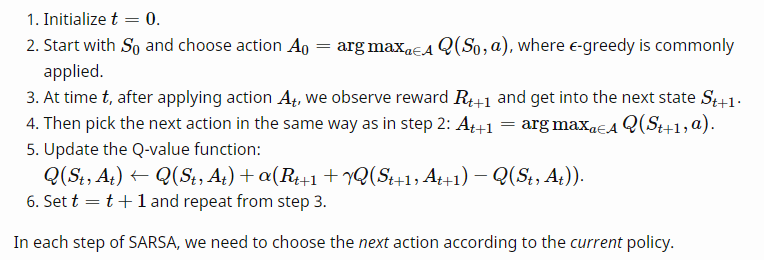

* Are you resetting too frequently / wiping memory or similar?
* Could it be an awfully tuned parameter?
* Check that parameters even impact the output as you'd expect
* Shouldn't be particularly sensitive to parameters, this is not a deep neural net or similar
* Q-values look off.
* Need to generate and disprove theories.
* Precise implementation is everything. 
* Beware of lazy scopes -> implement more in classes (even algorithms as classes because you can very neatly store memory as attributes)

In [59]:
# Maybe the N0 is the problem?

def reset():
    Q = np.zeros((22, 11, len(actions))) # state-action value
    NSA = np.zeros((22, 11, len(actions))) # state-action counter
    wins = 0

    return Q, NSA, wins

Q, NSA, wins = reset()

# seems to have made a difference, might be related to scopes?
def NS(NSA, p, d):
    return np.sum(NSA[p, d])


def alpha(NSA, p, d, a):
    return 1/NSA[p, d, a]


# exploration probability
def epsilon(NSA, p, d, N0):
    return N0 / (N0 + NS(NSA, p, d))


def epsilonGreedy(NSA, p, d, N0):
    if np.random.random() < epsilon(NSA, p, d, N0):
        # explore
        action = np.random.choice(actions)

    else:
        # exploit
        action = np.argmax( [Q[p, d, a] for a in actions] )

    return action

peak = Qs =  []

def sarsa(episodes, lmds, N0, actions):
    """
    State -> Action -> Reward -> State -> Action
    """
    wins_list_list = NSAs = Qs = []
    for li, lmd in enumerate(lmds):
        
        wins_list = []
        ties = losses = 0

        Q, NSA, wins = reset()

        for episode in range(episodes):
        
            terminated = False
            E = np.zeros((22, 11, len(actions))) # Eligibility Trace
            env = Easy21()
            p, d = env.player_score, env.dealer_score

            # initial state and first action
            a = epsilonGreedy(NSA, p, d, N0)
            
            # just moved this to the more sensible place.
            SA = list()
            
            # Sample Environment
            # Does your system terminate a step too early or too late? -> very possible. Think this must be it ?!
            while not terminated:

                pPrime, dPrime, r, terminated = env.step(p, d, a)

                if not terminated:
                    aPrime = epsilonGreedy(NSA, pPrime, dPrime, N0)
                    tdError = r + Q[pPrime, dPrime, aPrime] - Q[p, d, a]
                else:
                    tdError = r - Q[p, d, a]

                E[p, d, a] += 1
                NSA[p, d, a] += 1
                SA.append([p, d, a])

                for (_p, _d, _a) in SA:
                    # algo
                    Q[_p, _d, _a] += alpha(NSA, _p, _d, _a) * tdError * E[_p, _d, _a]
                    #Q[_p, _d, _a] += alpha(_p, _d, _a) * tdError * E[_p, _d, _a]
                    E[_p, _d, _a] *= lmd
                    
                    # debugging
                    Qs.append(Q[_p, _d, _a])
                    
                    #if alpha(NSA, _p, _d, _a) != float('inf'):
                    #    print(f'alpha = {alpha(_p, _d, _a)}')
                    #    print('BROKEN')
                        

                if not terminated:
                    # I reckon this bit is where it's going wrong -> the feedback loop just isn't feeding
                    p, d, a = pPrime, dPrime, aPrime
                    
            # Q values are clearly off.
            NSAs.append(np.sum(NSA))

            # bookkeeping
            if r == 1: # at the end of the game => r = -1 or 1 at this point
                wins += 1
            elif r == -1:
                losses += 1
            else:
                ties += 1
                
            wins_list.append(wins/(episode+1))
            
            if episode % 100000 == 0 or episode+1==episodes:
                print(f"Lambda={lmd} Episode {episode}, Wins {wins/(episode+1)}. Ties over total = {ties / (wins + losses + ties)}")
                
        wins_list_list.append(wins_list)
        print("--------")
        
    return wins_list_list, Qs, tests, NSAs, Q
        

# Input Parameters 
N0 = 100
actions = [0, 1]
episodes = int(5e6)
#lmds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8] 
lmds = [0.7]
wins_list_list, Qs, tests, NSAs, Q = sarsa(episodes, lmds, N0, actions)

Lambda=0.7 Episode 0, Wins 0.0. Ties over total = 1.0
Lambda=0.7 Episode 10000, Wins 0.3474652534746525. Ties over total = 0.09599040095990401
Lambda=0.7 Episode 20000, Wins 0.3534323283835808. Ties over total = 0.07334633268336584
Lambda=0.7 Episode 30000, Wins 0.3596546781773941. Ties over total = 0.05966467784407187
Lambda=0.7 Episode 40000, Wins 0.36086597835054124. Ties over total = 0.05132371690707732
Lambda=0.7 Episode 50000, Wins 0.36309273814523707. Ties over total = 0.04517909641807164
Lambda=0.7 Episode 60000, Wins 0.3636606056565724. Ties over total = 0.04019933001116648
Lambda=0.7 Episode 70000, Wins 0.3664661933400951. Ties over total = 0.036285195925772486
Lambda=0.7 Episode 80000, Wins 0.3671204109948626. Ties over total = 0.033162085473931575
Lambda=0.7 Episode 90000, Wins 0.3677292474528061. Ties over total = 0.030732991855646048
Lambda=0.7 Episode 100000, Wins 0.36853631463685366. Ties over total = 0.02870971290287097
Lambda=0.7 Episode 110000, Wins 0.368442105071772

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

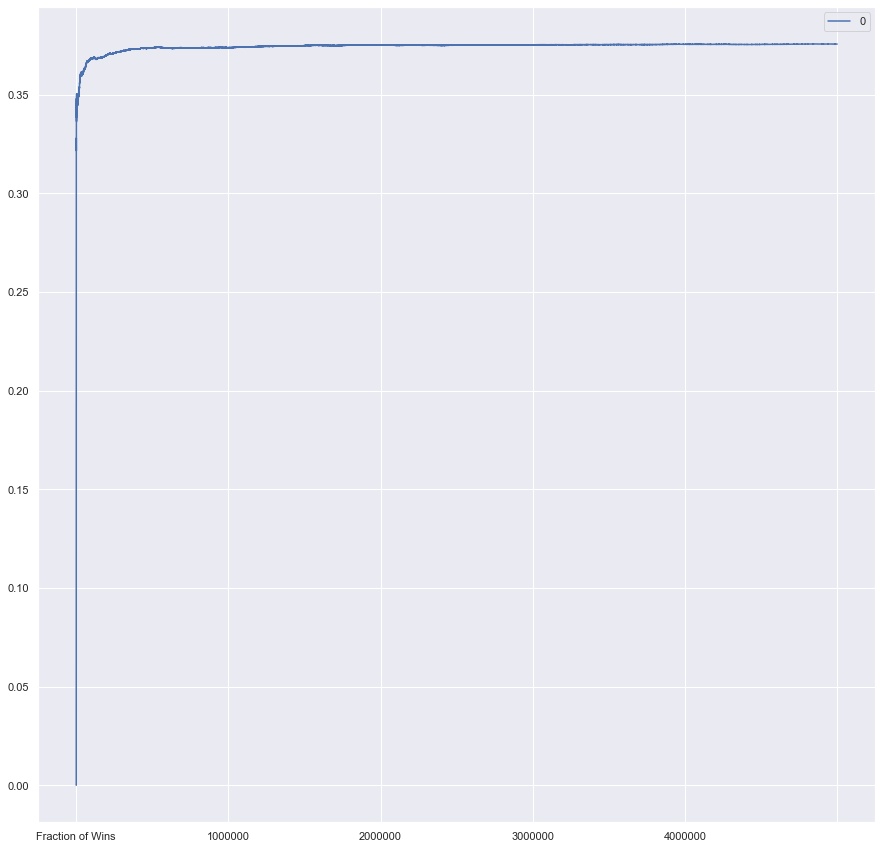

In [68]:
df = pd.DataFrame(wins_list_list[:10000]).rename(columns={0:'Fraction of Wins'})
df.T.plot(figsize=(15,15))

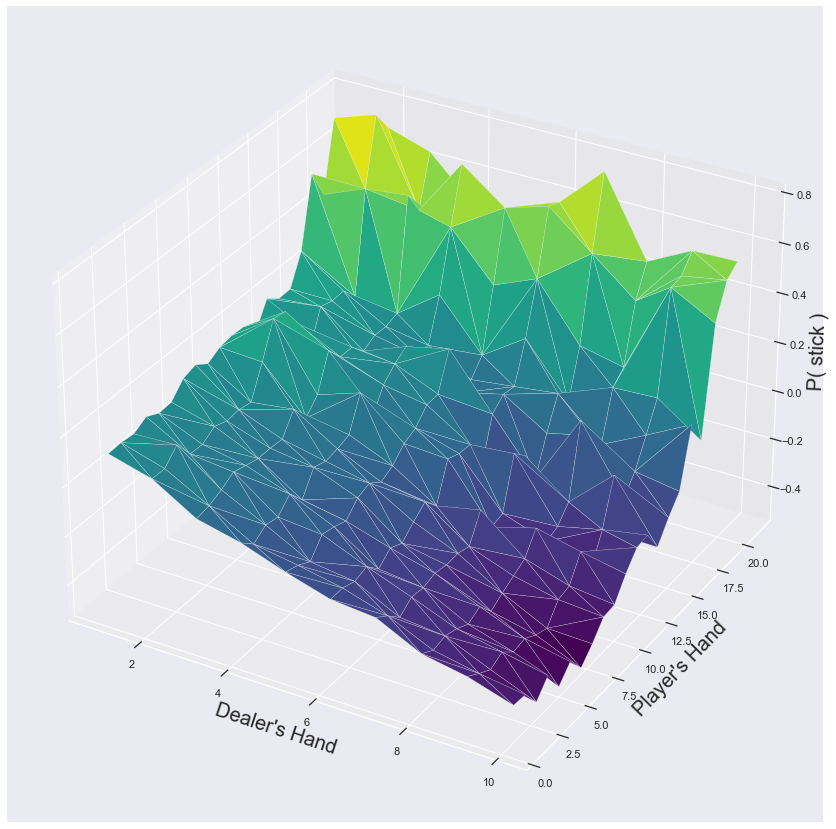

In [61]:
plot(Q, [0,1])